In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data Loading

In [4]:
# Load Data
video_df = pd.read_csv("videos-stats.csv")
comm_df = pd.read_csv("comments.csv")

# Drop Unnamed: 0 column
video_df = video_df.drop(columns=["Unnamed: 0"])
comm_df = comm_df.drop(columns=["Unnamed: 0"])

# Change column names
video_df = video_df.rename(columns={'Title':'video_title',
                                    'Video ID':'video_id',
                                    'Published At':'video_publish_date',
                                    'Keyword':'keyword',
                                    'Likes':'video_num_likes',
                                    'Comments':'video_num_comments',
                                    'Views':'video_num_views'})
comm_df = comm_df.rename(columns={'Video ID':'video_id',
                                  'Comment':'comment',
                                  'Likes':'comm_num_likes',
                                  'Sentiment':'comm_sentiment'})

# Drop nan values
video_df = video_df.dropna()
comm_df = comm_df.dropna()

# Drop duplicates
video_df.drop_duplicates(keep='first', inplace=True)
comm_df.drop_duplicates(keep='first', inplace=True)

# Text Cleaning

In [5]:
!pip install emoji
import emoji
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
import re
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def clean_text(text):

    # Remove \r and \n
    text = text.replace('\r', '').replace('\n', ' ').lower()

    # Remove links and mentions
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)

    # Remove emojis
    text = emoji.demojize(text).replace('_', ' ')

    # Remove non utf8/ascii characters
    text = re.sub(r'[^\x00-\x7f]',r'', text)

    # Remove hashtags
    text = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', text))
    text = " ".join(word.strip() for word in re.split('#|_', text))

    # Tokenize the text
    tokens = word_tokenize(text)

    # Convert to lowercase and remove non-alphabetic tokens
    tokens = [t.lower() for t in tokens if t.isalpha()]

    # Remove stop words and punctuation, and lemmatize
    stop_words = stopwords.words('english')
    punctuation = list(string.punctuation+'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'+'$'+'&')
    tokens_to_remove = stop_words + punctuation
    lemma = WordNetLemmatizer()
    tokens = [lemma.lemmatize(t) for t in tokens if t not in tokens_to_remove]

    return ' '.join(tokens)

def preprocess_df(df, max_seq_len=None):
    # Clean the comments
    df['new_comment'] = df['comment'].apply(clean_text)

    # Add comment lengths
    df['comment_len'] = df['new_comment'].apply(lambda x: len(str(x).split()))

    # Removing empty comments
    new_df = df[df['comment_len'] > 0]

    # Remove outliers
    if max_seq_len is not None:
        new_df = new_df[new_df['comment_len'] <= max_seq_len]

    return new_df

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.8/433.8 kB 8.5 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [6]:
max_seq_len = 50
comm_df = preprocess_df(comm_df, max_seq_len)
merged_data = pd.merge(comm_df, video_df, on="video_id")[['new_comment', 'keyword']]

# Train-Test-Validation Splitting

In [7]:
X = merged_data['new_comment'].to_numpy()
y = merged_data['keyword'].to_numpy()

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42)

# One-hot Encoding Keywords

In [9]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse_output=False)
y_train = one_hot_encoder.fit_transform(y_train.reshape(-1, 1))
y_test = one_hot_encoder.transform(y_test.reshape(-1, 1))
y_val = one_hot_encoder.transform(y_val.reshape(-1, 1))

# Model Development with Pre-trained USE Embedding Layer

In [18]:
import tensorflow as tf
import tensorflow_hub as hub
tf.random.set_seed(42)

use_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # Variable sized input
                                        dtype=tf.string,
                                        trainable=False, # Keep the pretrained weight
                                        name="USE_encoder")

In [26]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers

num_epochs = 30
num_classes = 41
batch_size = 32

# Model with dense layers
model = tf.keras.Sequential([use_layer,
                             layers.Dense(1024, activation="relu", name="dense_1"),
                             layers.Dense(num_classes, activation="softmax", name="output_layer")
                             ], name="keyword_model_USE")


model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=num_epochs, verbose=1, restore_best_weights=True)

model.summary()

Model: "keyword_model_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE_encoder (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense_1 (Dense)             (None, 1024)              525312    
                                                                 
 output_layer (Dense)        (None, 41)                42025     
                                                                 
Total params: 257365161 (981.77 MB)
Trainable params: 567337 (2.16 MB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [27]:
history = model.fit(X_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

Epoch 1/30
414/414 [==============================] - 10s 18ms/step - loss: 2.6147 - accuracy: 0.3533 - val_loss: 2.1808 - val_accuracy: 0.4269
Epoch 2/30
414/414 [==============================] - 8s 18ms/step - loss: 1.9514 - accuracy: 0.4774 - val_loss: 2.1093 - val_accuracy: 0.4494
Epoch 3/30
414/414 [==============================] - 5s 12ms/step - loss: 1.7901 - accuracy: 0.5129 - val_loss: 2.0982 - val_accuracy: 0.4487
Epoch 4/30
414/414 [==============================] - 7s 16ms/step - loss: 1.6734 - accuracy: 0.5397 - val_loss: 2.0864 - val_accuracy: 0.4460
Epoch 5/30
414/414 [==============================] - 5s 12ms/step - loss: 1.5688 - accuracy: 0.5649 - val_loss: 2.1003 - val_accuracy: 0.4426
Epoch 6/30
414/414 [==============================] - 8s 18ms/step - loss: 1.4673 - accuracy: 0.5921 - val_loss: 2.1102 - val_accuracy: 0.4521
Epoch 7/30
414/414 [==============================] - 6s 14ms/step - loss: 1.3681 - accuracy: 0.6183 - val_loss: 2.1252 - val_accuracy: 0.457

# Model Evaluation

In [44]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

def plot_conf_matrix(y_test, y_pred):
    y_pred_arg = np.argmax(y_pred, axis=1)
    y_test_arg = np.argmax(y_test, axis=1)

    cm = confusion_matrix(y_test_arg, y_pred_arg)
    fig, ax = plt.subplots(figsize=(15, 15))
    cmdisp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=merged_data['keyword'].unique())

    cmdisp.plot(ax=ax)
    plt.xticks(rotation=90)
    plt.show()

def calculate_acc(y_test, y_pred):
    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))
    print('Accuracy:', accuracy)

def plot_loss_acc(history):

    # Plot train-validation losses
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))
    epochs = range(1, len(history.history['loss']) + 1)
    ax[0].plot(epochs, history.history['loss'], marker='o', label='Train Loss')
    ax[0].plot(epochs, history.history['val_loss'], marker='o', label='Validation Loss')
    ax[0].set_title('Train and Validation Losses Over Epochs')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].grid(True)
    ax[0].legend(loc='upper right')

    # Plot train-validation accuracies
    ax[1].plot(epochs, history.history['accuracy'], marker='o', label='Train Accuracy')
    ax[1].plot(epochs, history.history['val_accuracy'], marker='o', label='Validation Accuracy')
    ax[1].set_title('Train and Validation Accuracies Over Epochs')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].grid(True)
    ax[1].legend(loc='upper left')

    plt.tight_layout()
    plt.show()

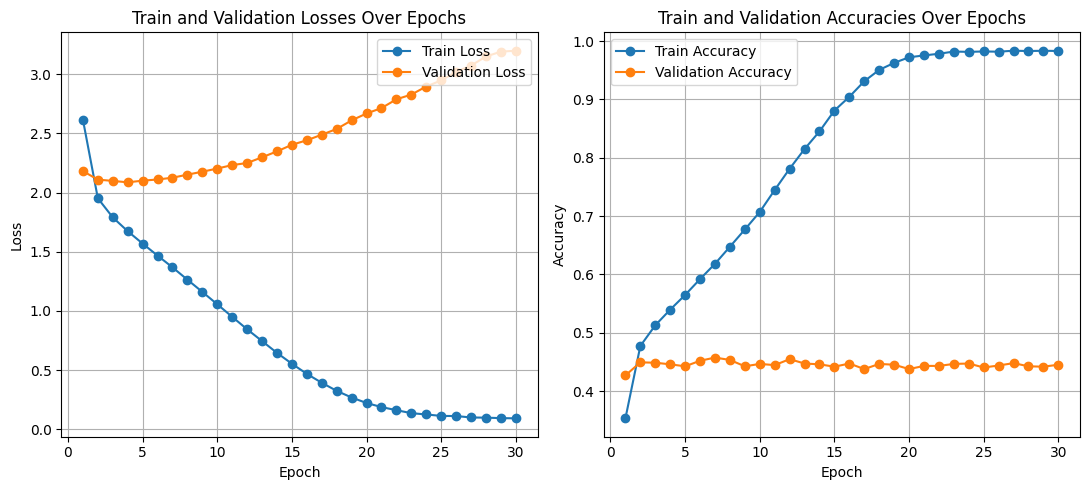

In [29]:
plot_loss_acc(history)

In [45]:
y_pred = model.predict(X_test)
calculate_acc(y_test, y_pred)

82/82 [==============================] - 3s 33ms/step
Accuracy: 0.44971098265895953


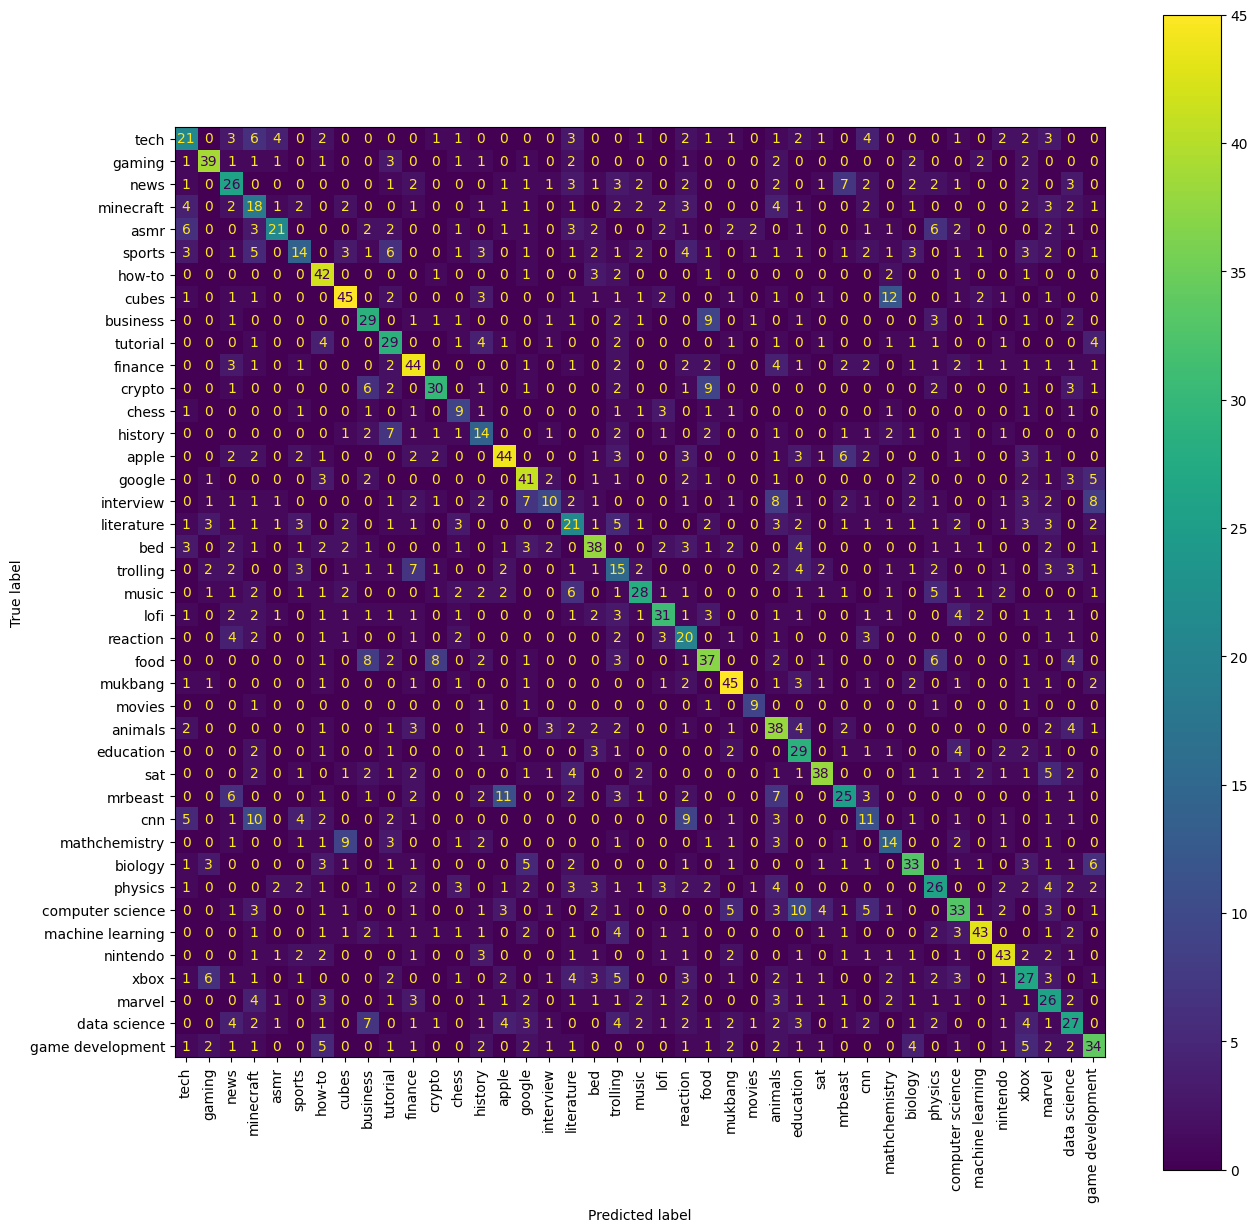

In [31]:
plot_conf_matrix(y_test, y_pred)

In [43]:
from sklearn.metrics import classification_report
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))


              precision    recall  f1-score   support

           0       0.38      0.34      0.36        62
           1       0.66      0.64      0.65        61
           2       0.38      0.39      0.39        66
           3       0.24      0.31      0.27        59
           4       0.60      0.33      0.43        63
           5       0.36      0.21      0.26        67
           6       0.51      0.78      0.61        54
           7       0.62      0.57      0.59        79
           8       0.43      0.52      0.47        56
           9       0.39      0.54      0.45        54
          10       0.52      0.56      0.54        78
          11       0.61      0.50      0.55        60
          12       0.28      0.38      0.32        24
          13       0.28      0.34      0.31        41
          14       0.58      0.55      0.56        80
          15       0.52      0.60      0.56        68
          16       0.38      0.16      0.23        61
          17       0.31    

In [34]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers

# Model with LSTM
model_lstm = tf.keras.Sequential([use_layer,
                                  tf.keras.layers.Reshape((1, 512), name='reshape_layer'),
                                  layers.Bidirectional(layers.LSTM(units=128, return_sequences=True), name='bidirectional_lstm_1'),
                                  layers.Bidirectional(layers.LSTM(units=64), name='bidirectional_lstm_2'),
                                  #layers.LSTM(units=100, return_sequences=True, name='lstm_1'),
                                  #layers.LSTM(units=50, name='lstm_2'),
                                  layers.Dense(41, activation="softmax", name='output_layer')
                                  ], name="lstm_use")

model_lstm.compile(loss="categorical_crossentropy",
                   optimizer=tf.keras.optimizers.Adam(),
                   metrics=["accuracy"])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, restore_best_weights=True)

model_lstm.summary()

Model: "lstm_use"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE_encoder (KerasLayer)    (None, 512)               256797824 
                                                                 
 reshape_layer (Reshape)     (None, 1, 512)            0         
                                                                 
 bidirectional_lstm_1 (Bidi  (None, 1, 256)            656384    
 rectional)                                                      
                                                                 
 bidirectional_lstm_2 (Bidi  (None, 128)               164352    
 rectional)                                                      
                                                                 
 output_layer (Dense)        (None, 41)                5289      
                                                                 
Total params: 257623849 (982.76 MB)
Trainable params: 8260

In [35]:
history_2 = model_lstm.fit(X_train,
                           y_train,
                           epochs=30,
                           validation_data=(X_val, y_val),
                           callbacks=[early_stopping])

Epoch 1/30
414/414 [==============================] - 36s 29ms/step - loss: 2.9020 - accuracy: 0.2489 - val_loss: 2.3885 - val_accuracy: 0.3793
Epoch 2/30
414/414 [==============================] - 9s 22ms/step - loss: 2.1662 - accuracy: 0.4190 - val_loss: 2.2249 - val_accuracy: 0.4167
Epoch 3/30
414/414 [==============================] - 9s 21ms/step - loss: 2.0004 - accuracy: 0.4580 - val_loss: 2.1799 - val_accuracy: 0.4208
Epoch 4/30
414/414 [==============================] - 10s 23ms/step - loss: 1.8968 - accuracy: 0.4832 - val_loss: 2.1359 - val_accuracy: 0.4405
Epoch 5/30
414/414 [==============================] - 11s 27ms/step - loss: 1.8192 - accuracy: 0.4979 - val_loss: 2.1249 - val_accuracy: 0.4378
Epoch 6/30
414/414 [==============================] - 11s 27ms/step - loss: 1.7490 - accuracy: 0.5186 - val_loss: 2.1139 - val_accuracy: 0.4412
Epoch 7/30
414/414 [==============================] - 8s 20ms/step - loss: 1.6840 - accuracy: 0.5360 - val_loss: 2.1194 - val_accuracy: 0.

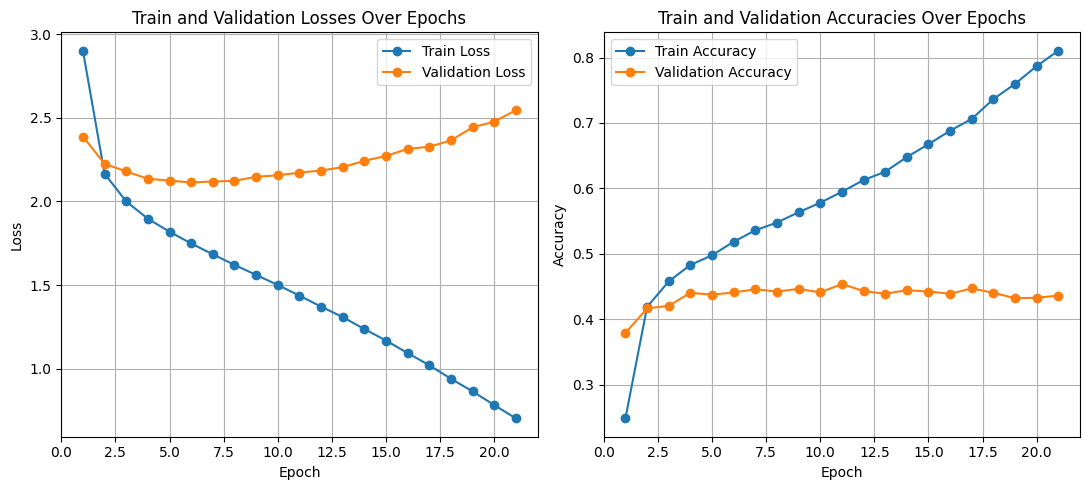

In [36]:
plot_loss_acc(history_2)

In [46]:
y_pred = model_lstm.predict(X_test)
calculate_acc(y_test, y_pred)

82/82 [==============================] - 1s 14ms/step
Accuracy: 0.4628131021194605


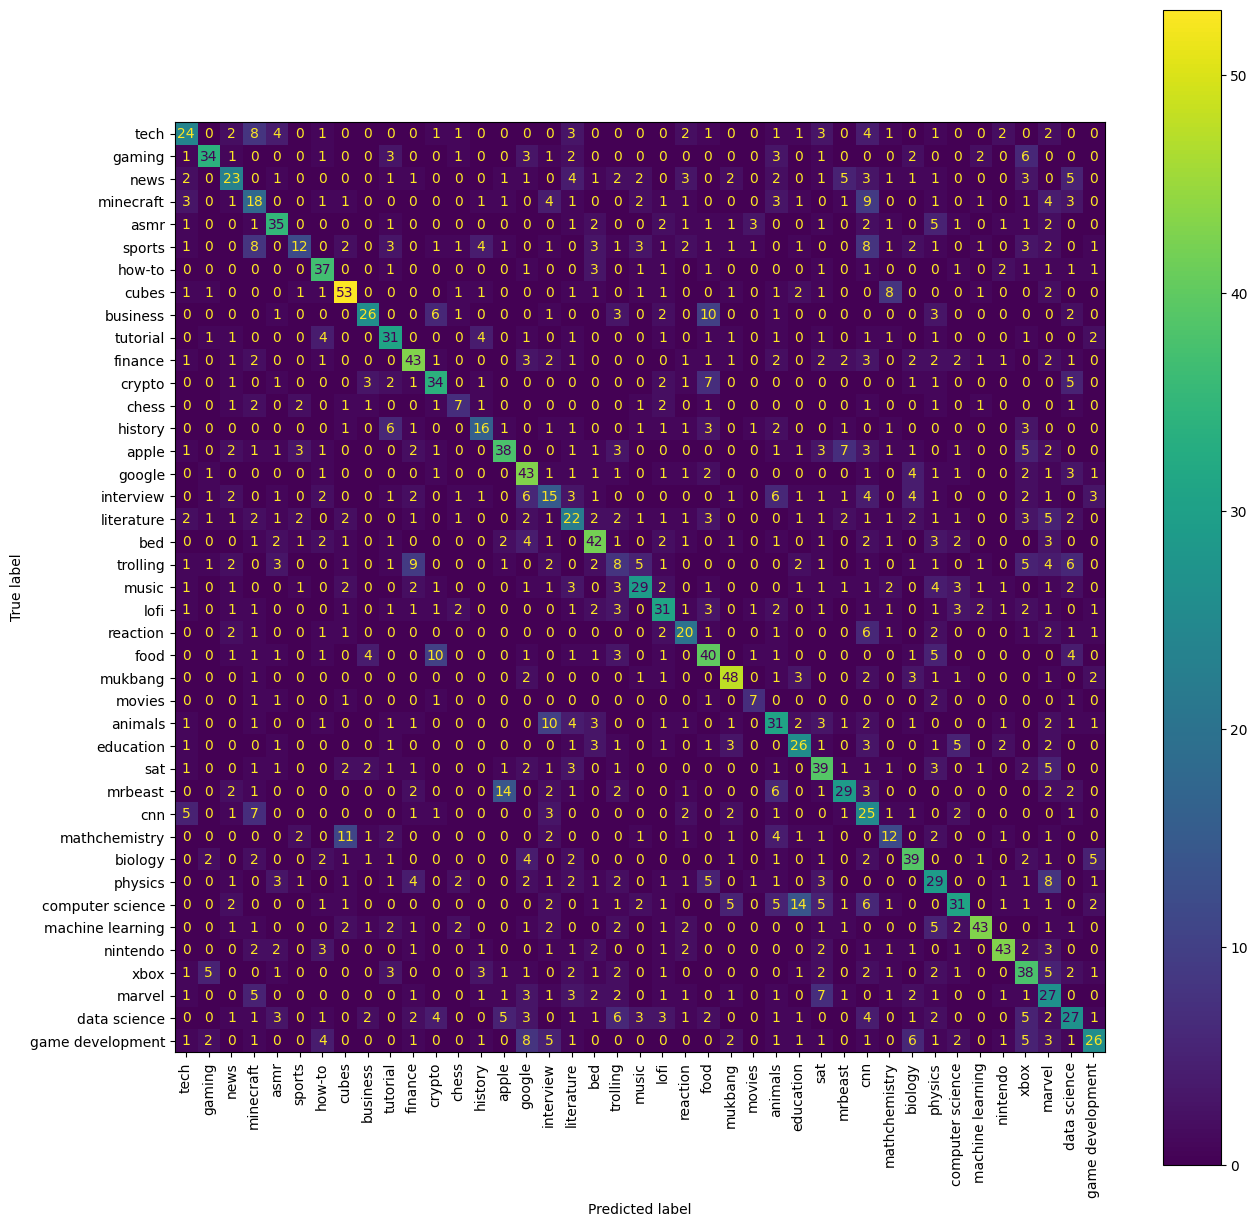

In [47]:
plot_conf_matrix(y_test, y_pred)

In [48]:
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.47      0.39      0.42        62
           1       0.69      0.56      0.62        61
           2       0.45      0.35      0.39        66
           3       0.26      0.31      0.28        59
           4       0.56      0.56      0.56        63
           5       0.48      0.18      0.26        67
           6       0.56      0.69      0.62        54
           7       0.62      0.67      0.65        79
           8       0.63      0.46      0.54        56
           9       0.48      0.57      0.53        54
          10       0.55      0.55      0.55        78
          11       0.53      0.57      0.55        60
          12       0.35      0.29      0.32        24
          13       0.46      0.39      0.42        41
          14       0.57      0.47      0.52        80
          15       0.47      0.63      0.54        68
          16       0.25      0.25      0.25        61
          17       0.32    

## Analysis and Comparison of Keyword Prediction Models

### **First Model** *(Without **LSTM**)*

**Architecture:** USE -> Dense(512) -> Dense(41)

**Performance:**
- **Overall Accuracy:** 0.45
- **Macro Avg:**
  - Precision: 0.45
  - Recall: 0.45
  - F1-Score: 0.44
- **Weighted Avg:**
  - Precision: 0.46
  - Recall: 0.45
  - F1-Score: 0.45

**Class-wise Performance:**
- Precision, Recall, and F1-Scores vary significantly across different classes.
- Some classes have relatively higher scores (e.g., class 7, 10, 14, 24) while others are lower (e.g., class 3, 16, 19, 30).

### **Second Model** *(With ***LSTM***)*

**Architecture:** USE -> BiLSTM(64) -> BiLSTM(64) -> Dense(41)

**Performance:**
- **Overall Accuracy:** 0.46
- **Macro Avg:**
  - Precision: 0.47
  - Recall: 0.46
  - F1-Score: 0.46
- **Weighted Avg:**
  - Precision: 0.48
  - Recall: 0.46
  - F1-Score: 0.46

**Class-wise Performance:**
- Improved precision, recall, and F1-Scores for several classes compared to the first model.
- More consistent performance across different classes.
- Some classes still perform poorly (e.g., class 5, 19, 30) while others show notable improvements (e.g., class 0, 6, 7, 24).





### **Comparative Analysis**

1. **Overall Accuracy:**
   - The second model (with LSTM) has a slightly higher overall accuracy (0.46) compared to the first model (0.45).

2. **Macro and Weighted Averages:**
   - The second model shows better macro and weighted averages across precision, recall, and F1-scores, indicating a more balanced performance across all classes.

3. **Class-wise Performance:**
   - The second model generally performs better across most classes, showing improvements in precision, recall, and F1-scores for a majority of the classes.
   - The first model struggles with certain classes (e.g., class 5, 16, 19, 30), and while the second model also has difficulties with these classes, it still shows slight improvements.

### **Conclusion**

Selected Model: **Second Model** *(with **LSTM**)*
- **Advantages:**
  - Slightly higher overall accuracy and better balanced performance across classes.
  - Improved macro and weighted averages.
  - Better handling of sequential data due to the LSTM layers, which likely contributes to its improved performance on keyword prediction from comments.

- **Disadvantages:**
  - While improvements are seen, some classes still perform poorly, indicating potential areas for further model refinement and optimization.

**Recommendations for Improvement:**
- **Hyperparameter Tuning:** Experiment with different LSTM layer sizes, dropout rates, and learning rates to further enhance model performance.
- **Class Imbalance Handling:** Implement techniques like oversampling, undersampling, or class weighting to address the imbalance among classes.
- **Feature Engineering:** Consider incorporating additional features or pre-processing steps to provide the model with more relevant information.
- **Ensemble Methods:** Combine predictions from both models to leverage their strengths and mitigate their weaknesses.

Overall, the second model (with LSTM) is the better choice for predicting keywords of videos based on comments, but further improvements can be made to enhance its performance.
